In [115]:
import pandas as pd
from sklearn.ensemble import IsolationForest
df = pd.read_csv("states.csv")
import matplotlib.pyplot as plt

In [116]:
!python -V

Python 3.9.6


In [163]:
iforest = IsolationForest(n_estimators=1000).fit(df.iloc[:,1:])

In [164]:
iforestScores = iforest.score_samples(df.iloc[:,1:])

In [165]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    feature_names = [f.replace(" ", "_")[:-5] for f in feature_names]
    print("def predict({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "    " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, np.round(threshold,2)))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, np.round(threshold,2)))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [166]:
a = df.columns


In [167]:
import statsmodels.api as sm


In [168]:
df2 = pd.concat([pd.DataFrame(iforestScores),df],axis=1)

df2.columns = a.insert(0,"Anomaly")

In [169]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
import numpy as np

regr = DecisionTreeRegressor(max_depth=5, random_state=1234)
X = df2[a[1:]]
model = regr.fit(df2[a[1:]], abs(df2['Anomaly']))

# Print rules
rules = get_rules(regr, df2.columns, None)

In [170]:
rules

['if (Poverty > 65.1) and (University <= 59549.5) and (Crime <= 1.885) and (White <= 339.5) and (Poverty > 84.15) then response: 0.427 | based on 20 samples',
 'if (Poverty > 65.1) and (University <= 59549.5) and (Crime <= 1.885) and (White <= 339.5) and (Poverty <= 84.15) then response: 0.454 | based on 12 samples',
 'if (Poverty > 65.1) and (University > 59549.5) and (States > 5.25) and (States <= 7.0) and (Crime > 0.955) then response: 0.501 | based on 2 samples',
 'if (Poverty > 65.1) and (University > 59549.5) and (States > 5.25) and (States <= 7.0) and (Crime <= 0.955) then response: 0.489 | based on 2 samples',
 'if (Poverty > 65.1) and (University <= 59549.5) and (Crime > 1.885) and (Traf Deaths > 4.4) and (Infant Mort <= 658.5) then response: 0.48 | based on 2 samples',
 'if (Poverty > 65.1) and (University <= 59549.5) and (Crime <= 1.885) and (White > 339.5) and (States > 5.55) then response: 0.502 | based on 2 samples',
 'if (Poverty > 65.1) and (University > 59549.5) and (S

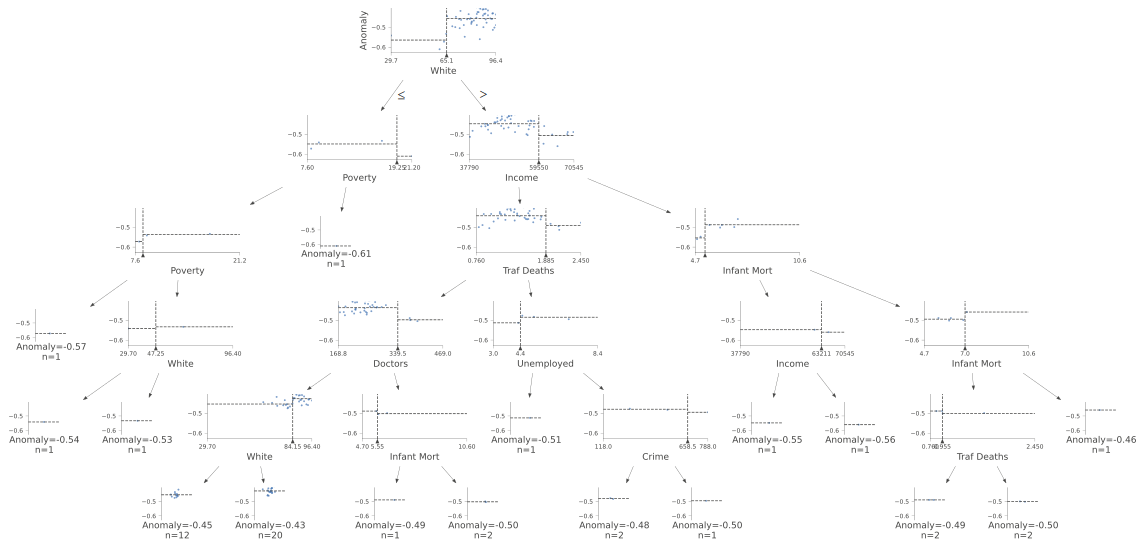

In [171]:
from dtreeviz.trees import dtreeviz # remember to load the package

viz = dtreeviz(model, X, df2['Anomaly'],
                target_name="Anomaly",
                feature_names=X.columns
              )

viz

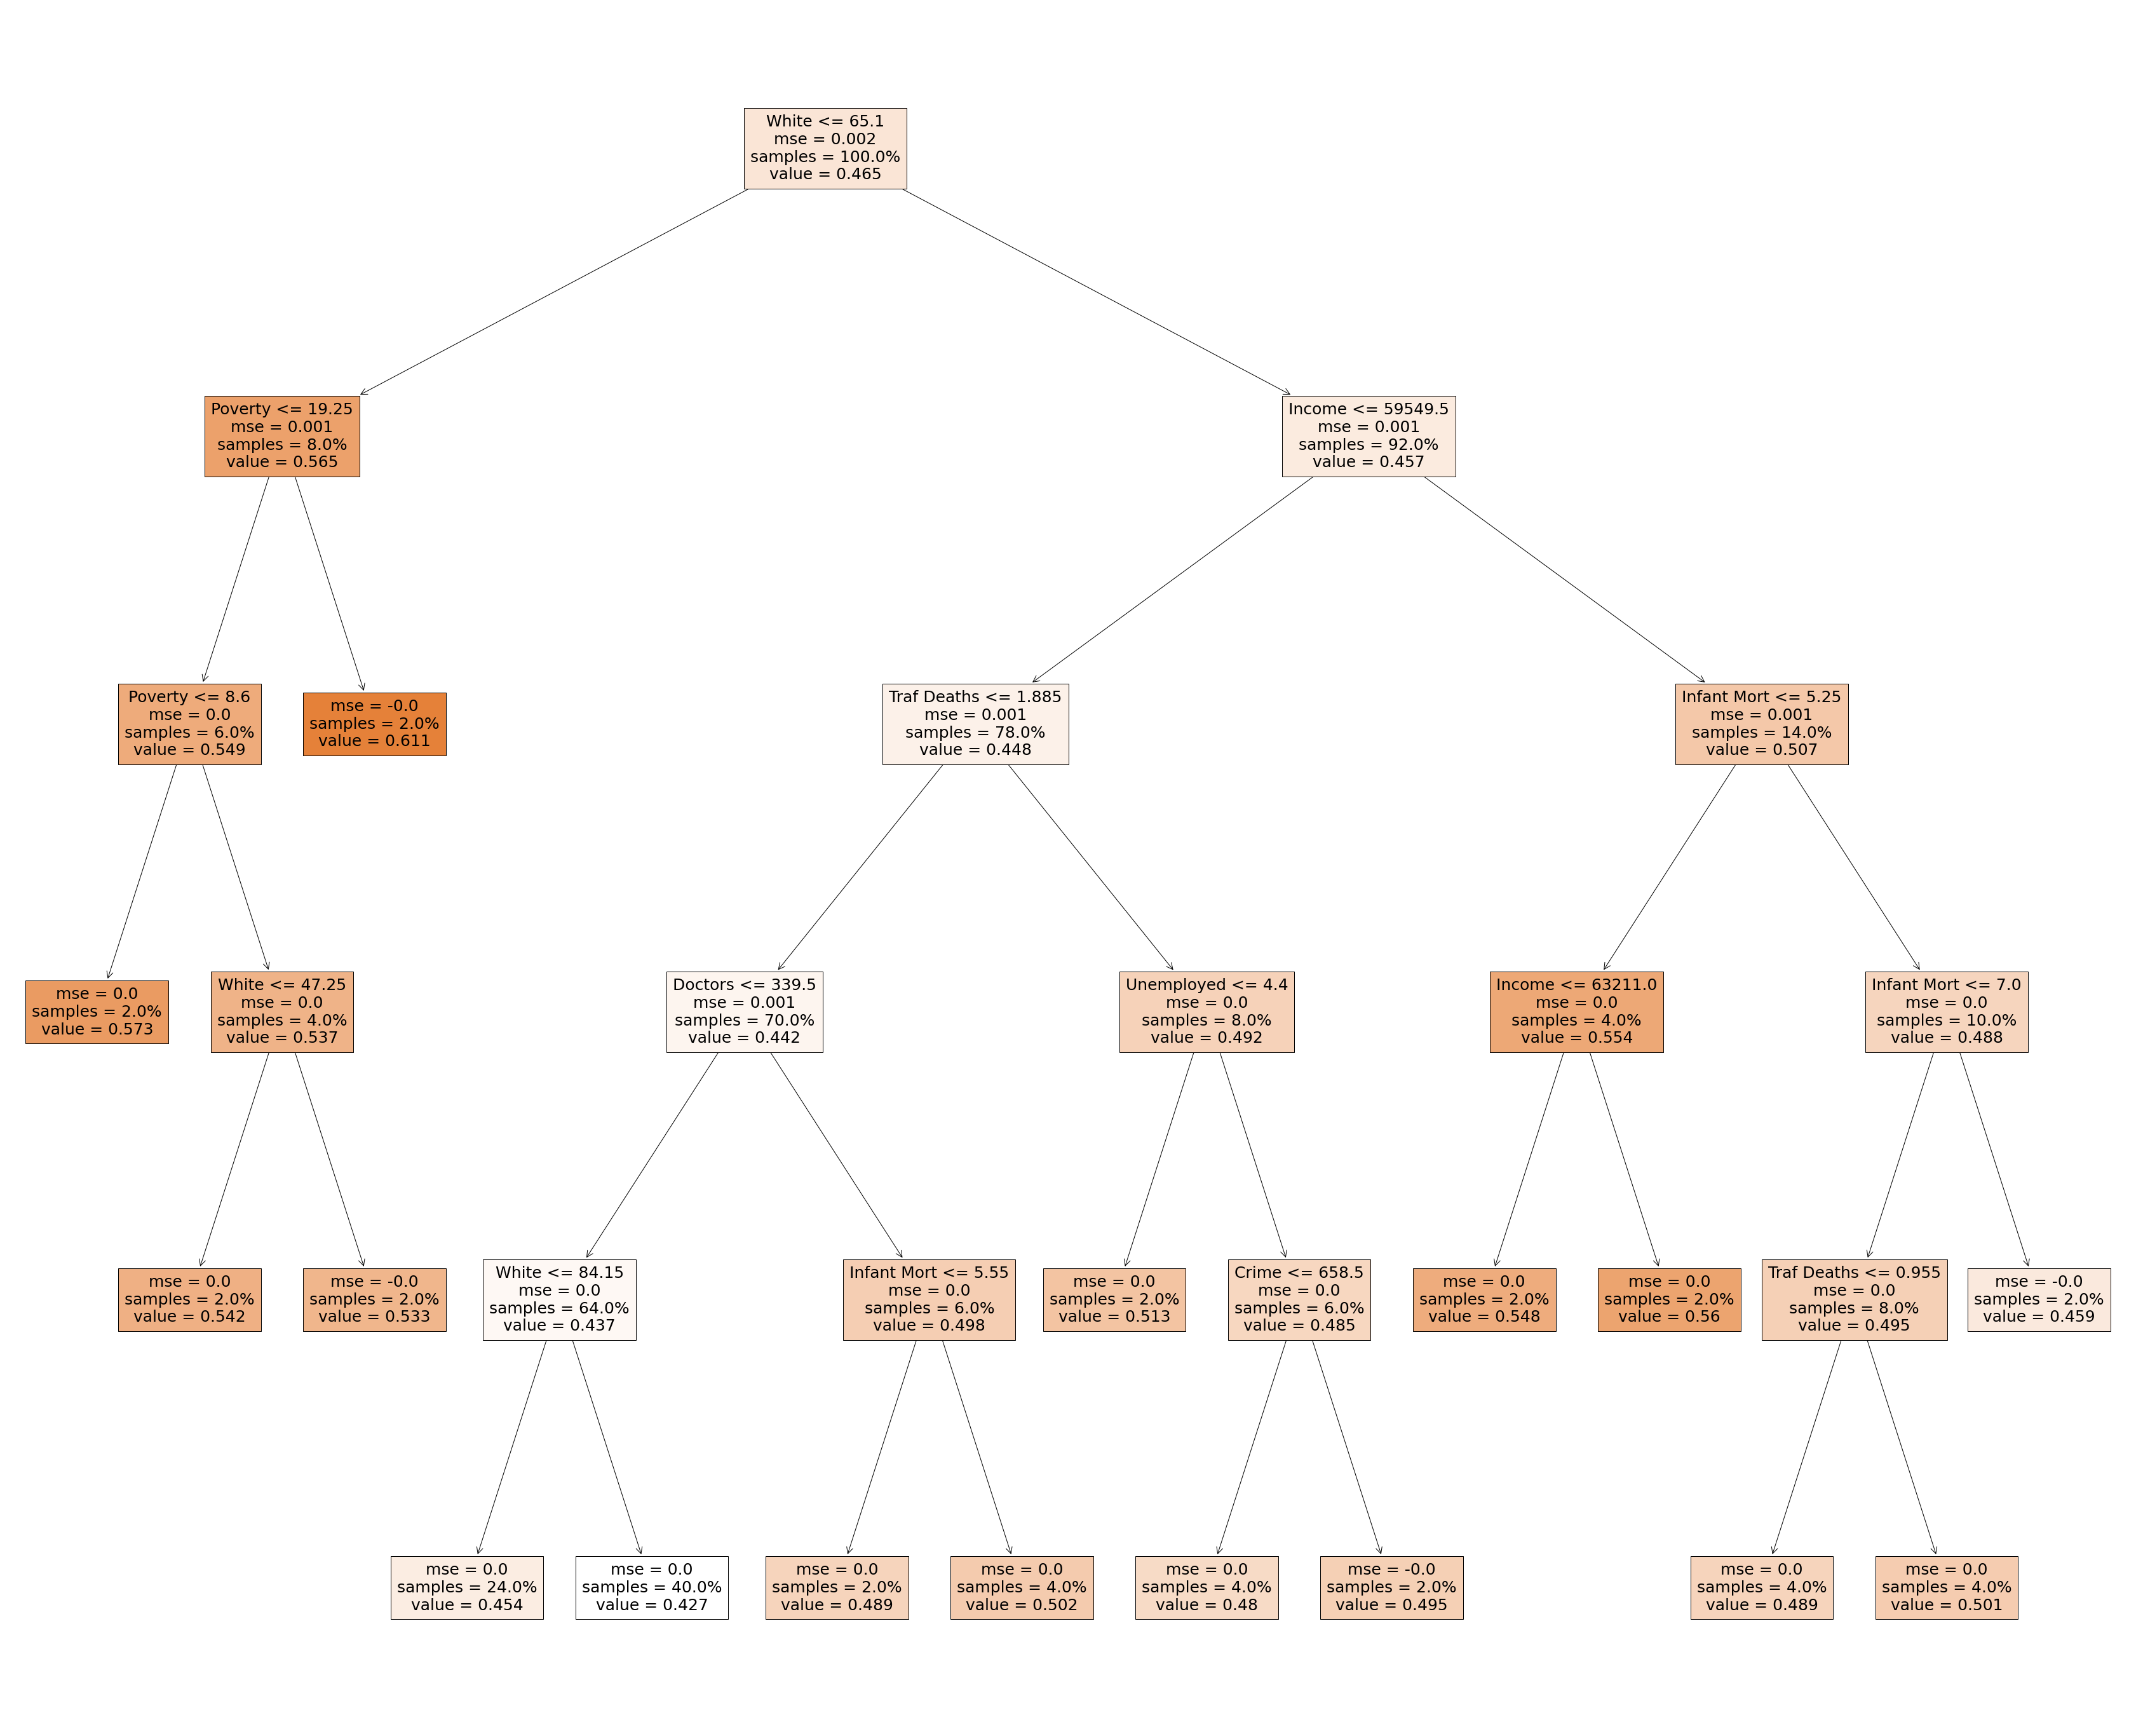

In [172]:
fig = plt.figure(figsize=(60,50))
_ = tree.plot_tree(regr, 
                   feature_names=a[1:],  
                   proportion = True,
                   #class_names=df2['States'],
                   #label=all,
                   filled=True)

In [173]:
import scipy.stats as st


In [197]:
#df2[a[1:]]
standardDevs = ((df2[a[1:]]-df2[a[1:]].describe().loc['mean'])/df2[a[1:]].describe().loc['std'])

mdist = pd.DataFrame((pd.DataFrame(st.norm.cdf(abs(standardDevs)),columns=standardDevs.columns).sum(axis=1)/len(standardDevs.columns)-.5)*2,columns=['mdist'])

#mdist = pd.DataFrame((st.norm.cdf(abs(((df2[a[1:]]-df2[a[1:]].describe().loc['mean'])/df2[a[1:]].describe().loc['std'])).sum(axis=1)/len(df2[a[1:]].columns)/2)-.5)*2,columns=['mdist'])
#mdist = pd.DataFrame(abs(((df2[a[1:]]-df2[a[1:]].describe().loc['mean'])/df2[a[1:]].describe().loc['std'])).sum(axis=1),columns=['mdist'])

In [175]:
from zca import zca
import numpy as np

N = 100
K= 4

data = np.random.rand(N, K)

zca = zca.ZCA()

# Separate fit and transform
zca.fit(standardDevs)

data_zca = zca.transform(standardDevs)

data_zca = zca.fit_transform(standardDevs)

In [198]:

#zcaS = pd.DataFrame(abs(data_zca),columns=standardDevs.columns)
zcaS = pd.DataFrame((pd.DataFrame(st.norm.cdf(abs(data_zca)),columns=standardDevs.columns).sum(axis=1)/len(df2[a[1:]].columns)-.5)*2,columns=['ZCAs'])
#zcaS = pd.DataFrame(zcaS.sum(axis=1),columns=['ZCAs'])

#zcaS = zcaS/len(df2[a[1:]].columns)/2
#zcaS = pd.DataFrame((st.norm.cdf(zcaS)-.5)*2,columns=['ZCAs'])
#zcaS =  pd.DataFrame((st.norm.cdf(pd.DataFrame(abs(data_zca),columns=standardDevs.columns).sum(axis=1)/len(df2[a[1:]].columns)/2)-.5)*2,columns=['ZCAs'])
#zcaS


array([[<AxesSubplot:title={'center':'ZCAs'}>]], dtype=object)

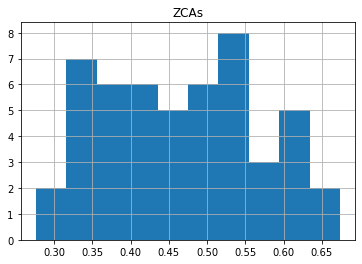

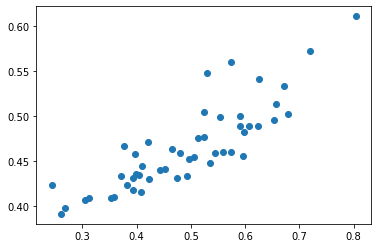

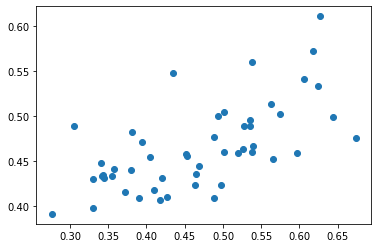

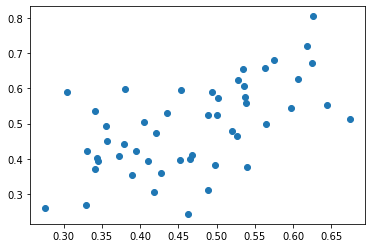

In [201]:
combined = pd.concat([mdist,zcaS,df2],axis=1)

plt.scatter(abs(combined['mdist']),abs(combined['Anomaly']))

plt.show()

plt.scatter(abs(combined['ZCAs']),abs(combined['Anomaly']))

plt.show()

plt.scatter(abs(combined['ZCAs']),abs(combined['mdist']))

plt.show()

In [202]:
display(combined.sort_values(kind="quicksort", ascending=True, by='mdist',key=abs))
display(combined.sort_values(kind="quicksort", ascending=True, by='ZCAs',key=abs))
display(combined.sort_values(kind="quicksort", ascending=True, by='Anomaly',key=abs))

,mdist,ZCAs,Anomaly,States,Poverty,Infant Mort,White,Crime,Doctors,Traf Deaths,University,Unemployed,Income,Population
37,0.243704,0.463287,-0.424300,Pennsylvania,12.1,7.6,85.4,417,305.3,1.37,26.3,5.4,50713,12517701
24,0.261286,0.276045,-0.391729,Missouri,13.4,7.4,85.0,505,246.0,1.43,25.0,6.1,46867,5905750
48,0.268269,0.329817,-0.398272,Wisconsin,10.4,6.4,89.7,291,259.1,1.27,25.7,4.7,52094,5601508
2,0.305395,0.417609,-0.407042,Arizona,14.7,6.4,86.5,483,209.7,1.69,25.1,5.5,50958,6360238
15,0.312488,0.488428,-0.409704,Kansas,11.3,7.1,88.7,453,222.5,1.38,29.6,4.4,50177,2773740
36,0.352832,0.389590,-0.409007,Oregon,13.6,5.5,90.1,288,274.5,1.31,28.1,6.4,50169,3730833
13,0.359310,0.426809,-0.410936,Indiana,13.1,8.0,88.0,334,216.9,1.26,22.9,5.9,47966,6344771
46,0.372141,0.341399,-0.433462,Washington,11.3,4.7,84.3,333,270.0,1.00,30.7,5.3,58078,6464167
42,0.377086,0.539275,-0.466392,Texas,15.8,6.2,82.4,511,214.2,1.38,25.3,4.9,50043,23824518
34,0.383025,0.497870,-0.423818,Ohio,13.4,7.8,84.8,343,266.7,1.14,24.1,6.5,47988,11518989


,mdist,ZCAs,Anomaly,States,Poverty,Infant Mort,White,Crime,Doctors,Traf Deaths,University,Unemployed,Income,Population
24,0.261286,0.276045,-0.391729,Missouri,13.4,7.4,85.0,505,246.0,1.43,25.0,6.1,46867,5905750
29,0.589919,0.304596,-0.489117,New Jersey,8.7,5.5,76.0,329,316.3,0.95,34.4,5.5,70378,8630810
48,0.268269,0.329817,-0.398272,Wisconsin,10.4,6.4,89.7,291,259.1,1.27,25.7,4.7,52094,5601508
11,0.422498,0.330006,-0.430033,Idaho,12.6,6.8,94.6,239,168.8,1.60,24.0,4.9,47576,1498390
0,0.534694,0.340413,-0.447812,Alabama,15.7,9.0,71.0,448,218.2,1.81,22.0,5.0,42666,4634063
46,0.372141,0.341399,-0.433462,Washington,11.3,4.7,84.3,333,270.0,1.00,30.7,5.3,58078,6464167
12,0.403657,0.343561,-0.434538,Illinois,12.2,7.3,79.1,533,280.2,1.16,29.9,6.5,56235,12775864
5,0.394352,0.345114,-0.431605,Colorado,11.4,5.7,89.7,348,259.7,1.14,35.6,4.9,56993,4837229
22,0.493641,0.355209,-0.433922,Minnesota,9.6,5.2,89.0,289,293.2,0.88,31.5,5.4,57288,5191267
40,0.451761,0.357382,-0.441249,South Dakota,12.5,6.9,88.2,169,219.1,1.62,25.1,3.0,46032,795521


,mdist,ZCAs,Anomaly,States,Poverty,Infant Mort,White,Crime,Doctors,Traf Deaths,University,Unemployed,Income,Population
24,0.261286,0.276045,-0.391729,Missouri,13.4,7.4,85.0,505,246.0,1.43,25.0,6.1,46867,5905750
48,0.268269,0.329817,-0.398272,Wisconsin,10.4,6.4,89.7,291,259.1,1.27,25.7,4.7,52094,5601508
2,0.305395,0.417609,-0.407042,Arizona,14.7,6.4,86.5,483,209.7,1.69,25.1,5.5,50958,6360238
36,0.352832,0.389590,-0.409007,Oregon,13.6,5.5,90.1,288,274.5,1.31,28.1,6.4,50169,3730833
15,0.312488,0.488428,-0.409704,Kansas,11.3,7.1,88.7,453,222.5,1.38,29.6,4.4,50177,2773740
13,0.359310,0.426809,-0.410936,Indiana,13.1,8.0,88.0,334,216.9,1.26,22.9,5.9,47966,6344771
26,0.408726,0.372005,-0.415794,Nebraska,10.8,5.6,91.4,302,245.4,1.32,27.1,3.3,49693,1768745
32,0.393212,0.409962,-0.418167,North Carolina,14.6,8.1,73.9,466,254.2,1.62,26.1,6.3,46549,9047856
34,0.383025,0.497870,-0.423818,Ohio,13.4,7.8,84.8,343,266.7,1.14,24.1,6.5,47988,11518989
37,0.243704,0.463287,-0.424300,Pennsylvania,12.1,7.6,85.4,417,305.3,1.37,26.3,5.4,50713,12517701


In [ ]:
plt.plot(abs(pd.Series(combined.sort_values(kind="quicksort", ascending=True, by='ZCAs',key=abs)['Anomaly'])).reset_index(drop=True))
plt.plot(abs(pd.Series(combined.sort_values(kind="quicksort", ascending=True, by='mdist',key=abs)['Anomaly'])).reset_index(drop=True))
plt.show()

In [ ]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

#fig, axes = plt.subplots(1, 2, )

ytdist = df2[a[1:]]
Z = hierarchy.linkage(ytdist, 'single')
plt.figure(figsize=(12, 10))
dn = hierarchy.dendrogram(Z)

In [ ]:
rules

In [ ]:
import imgkit

def highlight_greaterthan(x):
    if abs(x['Anomaly']) >= .6:
        return ['background-color: purple']*12
    elif abs(x['Anomaly']) >= .55:
        return ['background-color: red']*12
    elif abs(x['Anomaly']) >= .5:
        return ['background-color: yellow']*12
    else:
        return ['background-color: white']*12

html = df2.style.apply(highlight_greaterthan, axis=1).set_precision(2).render()

imgkit.from_string(html, 'state_anomalies.png')

In [ ]:
df2["Anomaly"].hist()